## Problem Statement

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.

 

After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. 

 

And this is where you come in as a data analyst. Your job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.  The datasets containing those socio-economic factors and the corresponding data dictionary are provided below.

#### Here I am going to do this Analysis based on the following Staps:
- Reading the Dataset
- Clean The Data & some EDA Analysis
- Checking outliers and its treatment
- Prepare the Data for Modelling
- Modelling
- Visualize and compare the data based on the clusters
- Finalizing the list of countries and Recommendation.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# Reading Dataset

country_data = pd.read_csv(r'D:\Download folder\Unsupervised Learning Clustering\Country-data.csv')
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
country_data.shape

(167, 10)

In [4]:
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
# Checking Null Value
country_data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [6]:
country_data.isnull().sum(axis=1)

0      0
1      0
2      0
3      0
4      0
      ..
162    0
163    0
164    0
165    0
166    0
Length: 167, dtype: int64

In [7]:
# Checking Duplicate value

country_data.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
162    False
163    False
164    False
165    False
166    False
Length: 167, dtype: bool

In [8]:
# Changing the exports, health and imports column from its % to actual value.

country_data['exports'] = (country_data['exports']*country_data['gdpp'])/100
country_data['health'] = (country_data['health']*country_data['gdpp'])/100
country_data['imports'] = (country_data['imports']*country_data['gdpp'])/100

As all the percentage columns are based on the GDP percentage and they are not well self explanatory based on their values. so I have converted those column to its actual value for its far better understanding.

In [9]:
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


**As after inspection there is no null value and duplicated value in the dataset, so there is no point of need of clean the dataset. So we can move further and do some EDA Analysis.**


## EDA ANALYSIS

### Derived Matrics

Here I am coping the main Dataset to s new one with a intention to not altering the main Dataset. Now creating bins for some column to perform EDA..

In [10]:
country_data_new = country_data.copy()
country_data_new.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [11]:
# Creating bins for gdpp column

bins = [0,500,1000,3000,5000,10000,15000,30000,50000,70000,100000,120000]
slot = ['0-500','500-1000','1000-3000','3000-5000','5000-10000','10000-15000','15000-30000','30000-50000','50000-70000','70000-100000','100000-120000']
country_data_new['gdpp_range'] = pd.cut(country_data_new['gdpp'],bins,labels=slot)

In [12]:
#Creating bins for child_mort column

bins = [0,5,10,30,50,70,100,120,150,180,210]
slot = ['0-5','5-10','10-30','30-50','50-70','70-100','100-120','120-150','150-180','180-210']
country_data_new['child_mort_range'] = pd.cut(country_data_new['child_mort'],bins,labels=slot)

In [13]:
# Creating bins for income column

bins = [0,500,1000,3000,5000,10000,15000,30000,50000,70000,100000,130000]
slot = ['0-500','500-1000','1000-3000','3000-5000','5000-10000','10000-15000','15000-30000','30000-50000','50000-70000','70000-100000','100000-120000']
country_data_new['income_range'] = pd.cut(country_data_new['income'],bins,labels=slot)

In [14]:
country_data_new.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,gdpp_range,child_mort_range,income_range
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,500-1000,70-100,1000-3000
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,3000-5000,10-30,5000-10000
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,3000-5000,10-30,10000-15000
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,3000-5000,100-120,5000-10000
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,10000-15000,10-30,15000-30000


### Bivariate Analysis

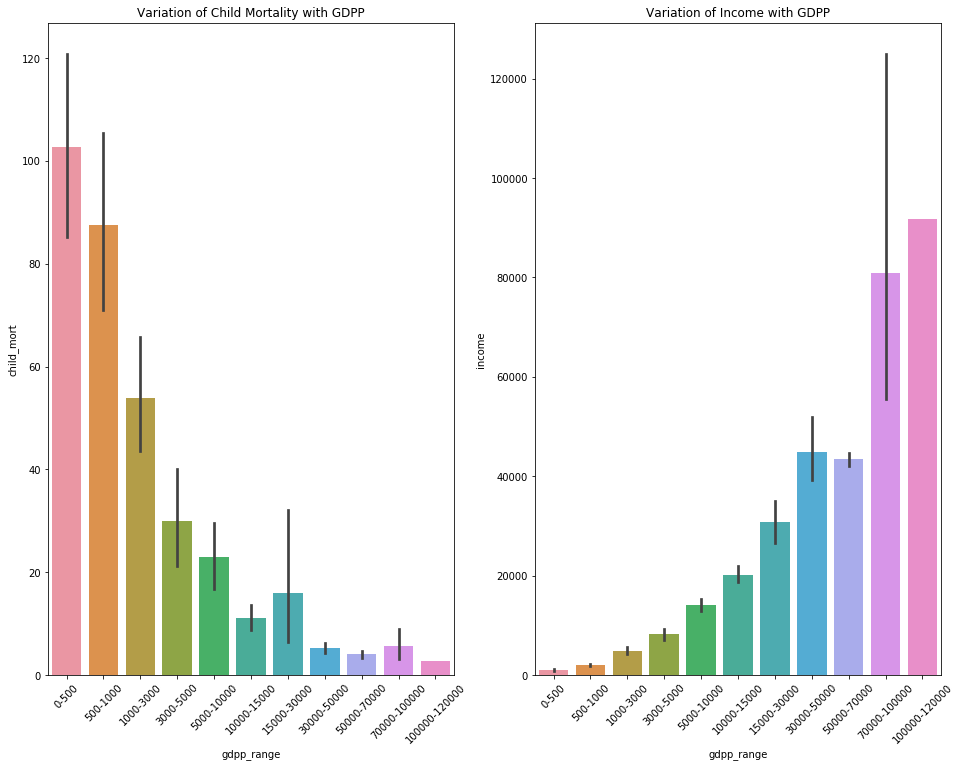

In [15]:
# Plotting barplot for GDPP with Child_mort & Income

plt.figure(figsize=(16,12))

plt.subplot(1,2,1)
plt.xticks(rotation=45)
sns.barplot(data=country_data_new, x='gdpp_range', y='child_mort')
plt.title('Variation of Child Mortality with GDPP')

plt.subplot(1,2,2)
plt.xticks(rotation=45)
sns.barplot(data=country_data_new, x='gdpp_range', y='income')
plt.title('Variation of Income with GDPP')

plt.show()

From two barplot it is clear that the countries with high GDP and high Income are socio-economically more Strong than the countries with low GDP and low Income. And from the 2nd barplot it is also clear that, the countries for which GDP is low their Income status is also low and it gradually increses with GDP.

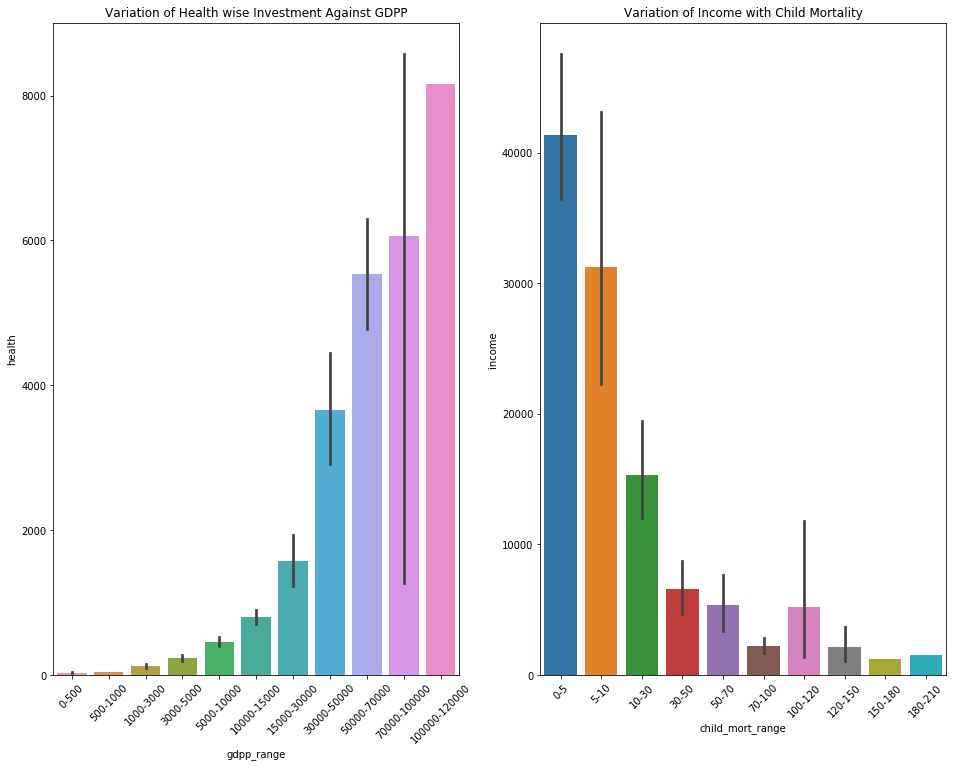

In [16]:
# Plotting barplot for GDPP with Health and Child_mort with Income

plt.figure(figsize=(16,12))

plt.subplot(1,2,1)
plt.xticks(rotation=45)
sns.barplot(data=country_data_new, x='gdpp_range', y='health')
plt.title('Variation of Health wise Investment Against GDPP')

plt.subplot(1,2,2)
plt.xticks(rotation=45)
sns.barplot(data=country_data_new, x='child_mort_range', y='income')
plt.title('Variation of Income with Child Mortality')

plt.show()

- Country with high GDP, Health investment is also high and vise-versa.
- In the other side, Countries having a high Income, are reflecting a very low Child Mortality rate and vise-versa.

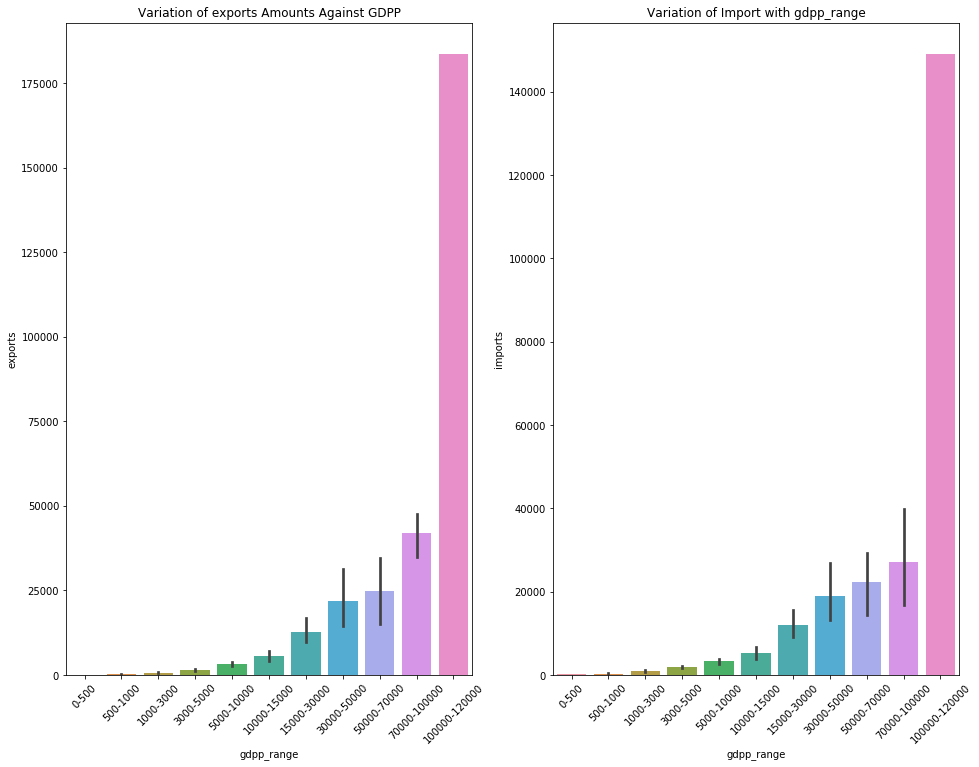

In [17]:
# Plotting barplot for GDPP with Exports & Imports

plt.figure(figsize=(16,12))

plt.subplot(1,2,1)
plt.xticks(rotation=45)
sns.barplot(data=country_data_new, x='gdpp_range', y='exports')
plt.title('Variation of exports Amounts Against GDPP')

plt.subplot(1,2,2)
plt.xticks(rotation=45)
sns.barplot(data=country_data_new, x='gdpp_range', y='imports')
plt.title('Variation of Import with gdpp_range')

plt.show()

- Here in this plots, we have got a quite expectable result that if the countries are having high GDP range they are well equiped with their Exportation and Imprtation mergins. That indicate a healthy scenario.

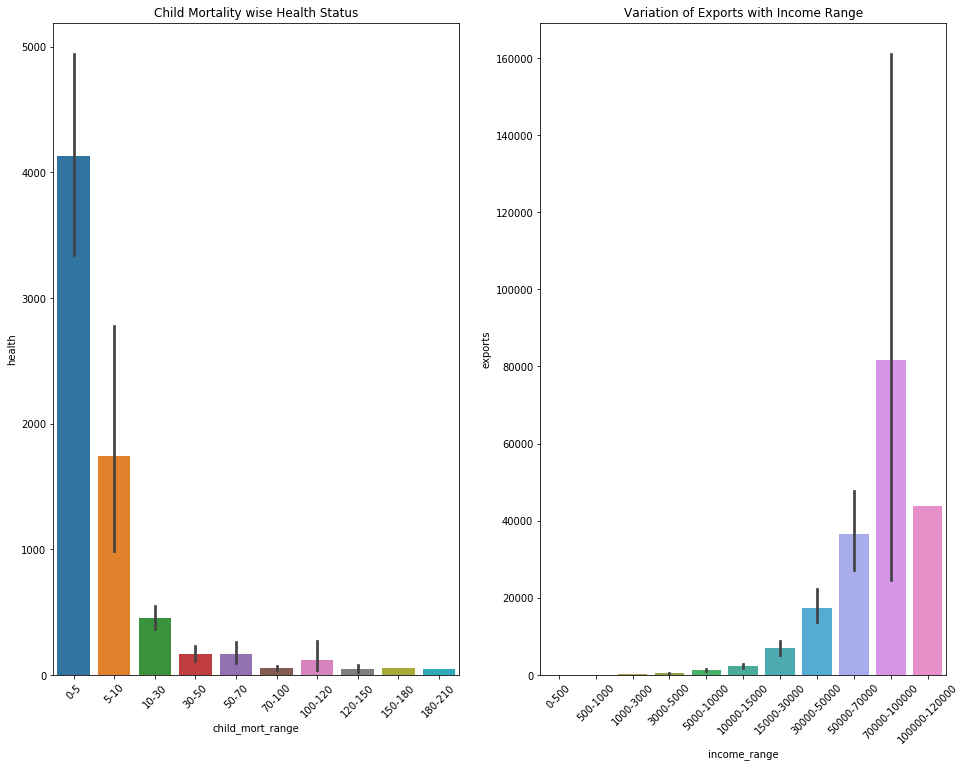

In [18]:
# Plotting barplot for Child Mortality with Health and Income with Exports

plt.figure(figsize=(16,12))

plt.subplot(1,2,1)
plt.xticks(rotation=45)
sns.barplot(data=country_data_new, x='child_mort_range', y='health')
plt.title('Child Mortality wise Health Status')

plt.subplot(1,2,2)
plt.xticks(rotation=45)
sns.barplot(data=country_data_new, x='income_range', y='exports')
plt.title('Variation of Exports with Income Range')

plt.show()

- From the 1st plot we can say that if the countries Health invesment is high for that countries Child Mortality Range become very low, and the Child Mortality become gradually increases when the countries are less care about their own health infrastructures.
- Similarly The countries having high Income range are well care about their Exportation to generate Revenues more for their intra-infrastructures and socio-economic developments. 

So finally from the above Bivariate Analysis, we can intituively say that, a countries' development are solily depend on their GDP, Income, Health Condition, Child Mortality Imports & Exports. These are the major factors which can play a significant role for a countries overall developments. If any one of the all factors are detoriated from its bench mark conditions then it may majorly create a remarkable advarse effect on the countries' developments.

### Univariate Analysis

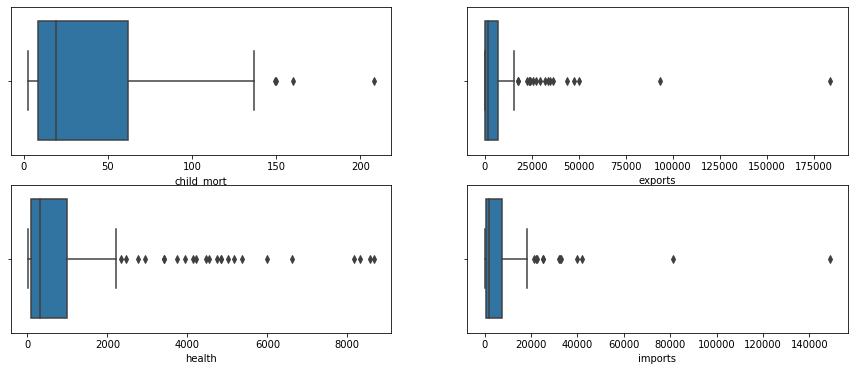

In [19]:
# Boxplot for columns index from 1 - 4

plt.figure(figsize = (15,6))
features = country_data.columns[1:5]
for i in enumerate(features):
    plt.subplot(2,2,i[0]+1)
    sns.boxplot(country_data[i[1]])

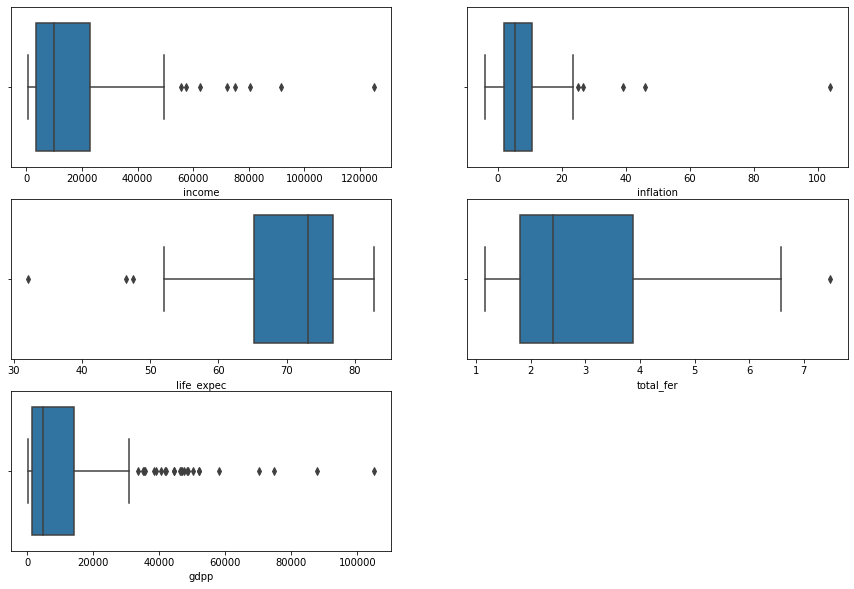

In [20]:
# Plotting boxplot for columns from 5 - 9

plt.figure(figsize = (15,10))
features = country_data.columns[5:10]
for i in enumerate(features):
    plt.subplot(3,2,i[0]+1)
    sns.boxplot(country_data[i[1]])

From the above boxplots it is clear that most of the variable have outliers at its upper range except one i.e. "life_expec". For Child Mortality it has very few outliers and it clearly indicate those countries, which we can intituively say, which are in direst need of AID. Median for Child_mort are lies in the 1st quartile range.

As almost all the column have outliers so before proceed for Modelling we have to teat the same. As our Data is small so we are not removing any outliers but make them cap and treat only the upper limit to its 99 percentile. As this range is a **Soft Range** so it will not alter our dataset so much.

**But here we should keep in Mid that we will not do anything with our "child_mort" column, because these outlied countries are our main target countries for which we can prepare our investments.**

### Outlier Treatment

In [21]:
# Capping the columns' outlier at its 99 percentile except Child_mort

q1 = country_data.total_fer.quantile(0.99)
country_data.total_fer[country_data['total_fer']>=q1] = q1
q2 = country_data.exports.quantile(0.99)
country_data.exports[country_data['exports']>=q2] = q2
q3 = country_data.imports.quantile(0.99)
country_data.imports[country_data['imports']>=q3] = q3
q4 = country_data.health.quantile(0.99)
country_data.health[country_data['health']>=q4] = q4
q5 = country_data.income.quantile(0.99)
country_data.income[country_data['income']>=q5] = q5
q6 = country_data.inflation.quantile(0.99)
country_data.inflation[country_data['inflation']>= q6] =q6
q7 = country_data.life_expec.quantile(0.99)
country_data.life_expec[country_data['life_expec']>=q7] = q7
q8 = country_data.gdpp.quantile(0.99)
country_data.gdpp[country_data['gdpp']>=q8] = q8

## Preparing Data for Modelling

In [22]:
country_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,6538.214776,1054.206622,5873.135222,16857.550898,7.380970,70.551138,2.942259,12756.826347
std,40.328931,11415.308590,1790.845342,9422.700869,17957.012855,7.793224,8.886987,1.498340,17430.208938
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,64794.260000,8410.330400,55371.390000,84374.000000,41.478000,82.370000,6.563600,79088.000000


In [23]:
# Check the hopkins

#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [24]:
hopkins(country_data.drop('country', axis = 1))

0.9518969313456392

 Upon multiple iteration Our **HOPKINS SCORE** clearly indicate that our data has a good form for clustering.

### Modelling

#### Rescalling Dataset

In [25]:
# Rescalling the dataset except country column

scaler = StandardScaler()

country_data_scaled = scaler.fit_transform(country_data.drop('country', axis=1))
country_data_scaled.shape

(167, 9)

### Finding the Optimul Number of Clusters

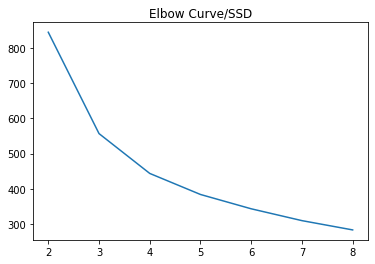

In [26]:
# Checking the elbow-curve/SSD
ssd = []
for i in range(2,9):
    kmeans = KMeans(n_clusters=i).fit(country_data_scaled)
    ssd.append([i, kmeans.inertia_])
    
# plot the SSDs for each n_clusters

temp = pd.DataFrame(ssd)
plt.plot(temp[0], temp[1])
plt.title('Elbow Curve/SSD')
plt.show()

In [27]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(country_data_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(country_data_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.46939671737315203
For n_clusters=3, the silhouette score is 0.40354315435737337
For n_clusters=4, the silhouette score is 0.39198240102217824
For n_clusters=5, the silhouette score is 0.3841728000208612
For n_clusters=6, the silhouette score is 0.29452758352144215
For n_clusters=7, the silhouette score is 0.2887054772823711
For n_clusters=8, the silhouette score is 0.30986120876784196


So after checking the **Elbow Curve** & **Silhouette Score** we can choose our **final K as 3**. Because We have seen that in the **Sum of Squared Distance** Curve the 1st knee like bend has come at the level of 3. and in the silhouette score, the score of k=3 is also considerable for clustering. Though in the silhouette score for 2 is quite impressive from score of 3, but intuitively we can say from the point of our dataset that choosing the cluster number at 2 might not give us a optimul result that we can expect for. So for better clustering and better outcome of our analysis, we will choose our final number of cluster as 3.

In [28]:
# Final Number of Cluster = 3

kmeans = KMeans(n_clusters = 3, random_state=50)
kmeans.fit(country_data_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [29]:
kmeans.labels_

array([2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 0,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 1, 0, 1, 2, 2, 0, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2])

In [30]:
# Copying our dataset

country_data_1 = country_data.copy()

In [31]:
# Assigning the lavels to our dataset and make the cluster for countries.

country_data_1['k_label'] = kmeans.labels_
country_data_1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,k_label
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


In [32]:
country_data_1.k_label.value_counts()

0    90
2    48
1    29
Name: k_label, dtype: int64

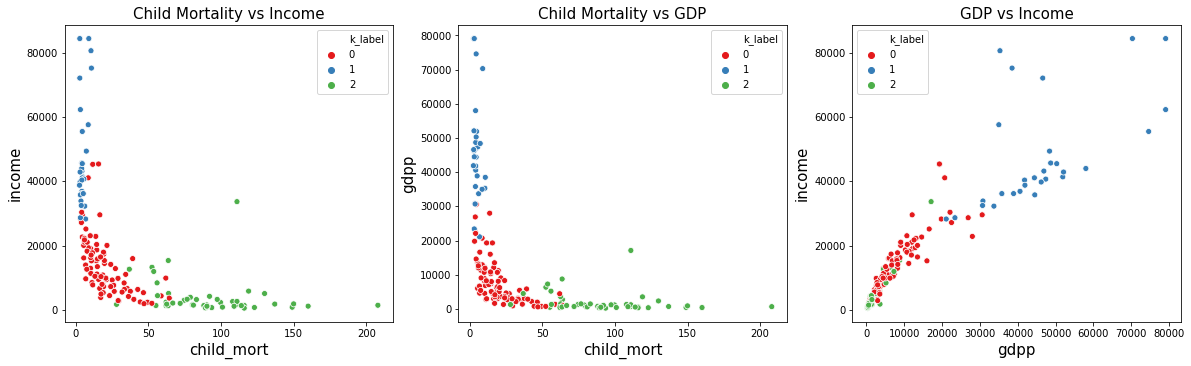

In [33]:
# Plot the cluster

plt.figure(figsize=(20,12))
plt.subplot(2,3,1)
sns.scatterplot(x = 'child_mort', y = 'income', hue = 'k_label', data = country_data_1, palette = 'Set1')
plt.xlabel('child_mort',fontsize=15)
plt.ylabel('income', fontsize=15)
plt.title('Child Mortality vs Income', fontsize=15)
plt.subplot(2,3,2)
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue = 'k_label', data = country_data_1, palette = 'Set1')
plt.xlabel('child_mort',fontsize=15)
plt.ylabel('gdpp', fontsize=15)
plt.title('Child Mortality vs GDP', fontsize=15)
plt.subplot(2,3,3)
sns.scatterplot(x = 'gdpp', y = 'income', hue = 'k_label', data = country_data_1, palette = 'Set1')
plt.xlabel('gdpp',fontsize=15)
plt.ylabel('income', fontsize=15)
plt.title('GDP vs Income', fontsize=15)
plt.show()

So after performing the K_Means algorithm and assigning the data point to its appropriate cluster number, and now by comparing the data points by the 3 major variables, we have seen that all the countries which are literally Socio-Economically very much poor and for which the child Mortality rate are much more high are **assigned to cluster number 2.** So we can intuitively say that these are the countries which are really in the direst need of AID and all the major investment should be planed for development by taking these countries into consideration.**We can be far more clear by moving ahead our analysis further.**

### Cluster Profilling

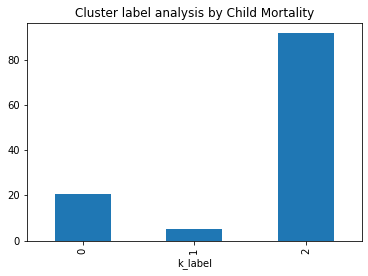

In [34]:
# Plotting the Child_mort by grouping the Label

country_data_1.groupby('k_label')['child_mort'].mean().plot(kind='bar')
plt.title('Cluster label analysis by Child Mortality')
plt.show()

From the bar plot it clear that majorly effected countries by Child Mortality rate are all assign in Number 2. So these are our prime target countries.

In [35]:
country_data_1.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp', 'k_label'],
      dtype='object')

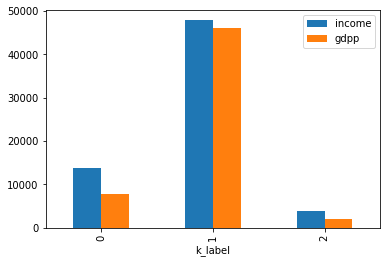

In [36]:
# Potting the Income And GDP by groupping Label

country_data_1.drop(['country','exports','health','imports','inflation','life_expec','total_fer','child_mort'], axis = 1).groupby('k_label').mean().plot(kind = 'bar')
plt.show()

From the above plot we can say that label 2 is our prime target countries. So now we are going to filter the data for that cluster.

In [37]:
# Low income, Low GDP and High Child_mort
# Filter the data for that clsuter

country_data_1[country_data_1['k_label'] == 2].head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,k_label
0,Afghanistan,90.2,55.300,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,2
3,Angola,119.0,2199.190,100.6050,1514.370,5900.0,22.400,60.1,6.16,3530.0,2
17,Benin,111.0,180.404,31.0780,281.976,1820.0,0.885,61.8,5.36,758.0,2
21,Botswana,52.5,2768.600,527.0500,3257.550,13300.0,8.920,57.1,2.88,6350.0,2
25,Burkina Faso,116.0,110.400,38.7550,170.200,1430.0,6.810,57.9,5.87,575.0,2


In [38]:
# Sorting k_label by child Mortality, Income & GDPP
country_data_1[country_data_1['k_label'] == 2].sort_values(by=['child_mort','income','gdpp'], ascending=[False,True,True]).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,k_label
66,Haiti,208.0,101.286,45.7442,428.314,1500.0,5.45,32.1,3.3300,662.0,2
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220.0,17.20,55.0,5.2000,399.0,2
32,Chad,150.0,330.096,40.6341,390.195,1930.0,6.39,56.5,6.5636,897.0,2
31,Central African Republic,149.0,52.628,17.7508,118.190,888.0,2.01,47.5,5.2100,446.0,2
97,Mali,137.0,161.424,35.2584,248.508,1870.0,4.37,59.5,6.5500,708.0,2


In [39]:
min(country_data_1.gdpp)

231.0

In [40]:
min(country_data_1.income)

609.0

## Hierarchical Clustering

In [41]:
country_data_scaled = pd.DataFrame(country_data_scaled)
country_data_scaled.columns = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']
country_data_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.569622,-0.566958,-0.598741,-0.851668,0.265002,-1.619705,1.926396,-0.702259
1,-0.538949,-0.473858,-0.440393,-0.413584,-0.386946,-0.372075,0.648831,-0.865054,-0.498726
2,-0.272833,-0.424000,-0.486271,-0.476100,-0.221053,1.122161,0.671403,-0.034983,-0.477434
3,2.007808,-0.381249,-0.534088,-0.463973,-0.612045,1.932987,-1.179541,2.153997,-0.530950
4,-0.695634,-0.086742,-0.178410,0.139728,0.125254,-0.764618,0.705262,-0.543736,-0.032042


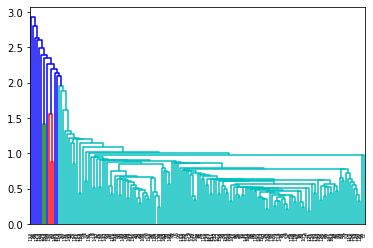

In [42]:
# Single Linkage

mergins = linkage(country_data_scaled,method ='single', metric='euclidean')
dendrogram(mergins)
plt.show()

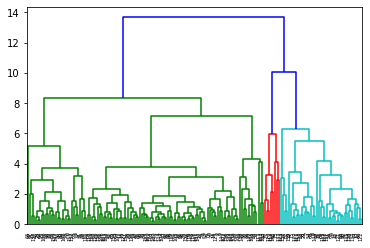

In [43]:
# Complete Linkage

mergins = linkage(country_data_scaled, method='complete', metric='euclidean')
dendrogram(mergins)
plt.show()

Now this dendrogram is far intuitive enough. we can clearly seen 3 different set of clusters by its colour green, red and sky.Majority of data point are filtered by green followed by sky and Red. So if we cut the tree and draw a horizontal line 8 to 10 w will get 3 distint set of cluster data which can give us far more interpretable understanding from our business point of view.

In [44]:
# Cutting the tree and applying 3 clusters

cluster_labels = cut_tree(mergins, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [45]:
# Assigning the cluster label to the dataset

country_data_1['cluster_label'] = cluster_labels
country_data_1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,k_label,cluster_label
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,1


In [46]:
country_data_1.cluster_label.value_counts()

0    118
1     41
2      8
Name: cluster_label, dtype: int64

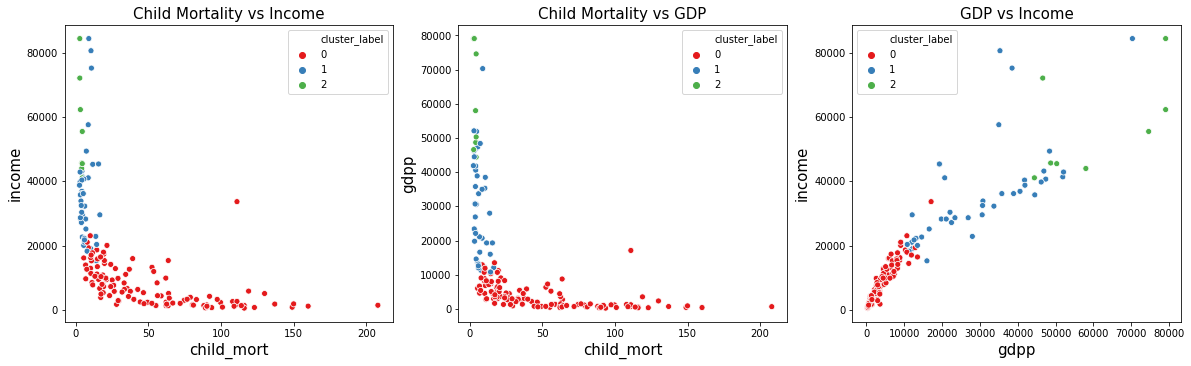

In [47]:
# Plot the cluster
plt.figure(figsize=(20,12))
plt.subplot(2,3,1)
sns.scatterplot(x = 'child_mort', y = 'income', hue = 'cluster_label', data = country_data_1, palette = 'Set1')
plt.xlabel('child_mort',fontsize=15)
plt.ylabel('income', fontsize=15)
plt.title('Child Mortality vs Income', fontsize=15)
plt.subplot(2,3,2)
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue = 'cluster_label', data = country_data_1, palette = 'Set1')
plt.xlabel('child_mort',fontsize=15)
plt.ylabel('gdpp', fontsize=15)
plt.title('Child Mortality vs GDP', fontsize=15)
plt.subplot(2,3,3)
sns.scatterplot(x = 'gdpp', y = 'income', hue = 'cluster_label', data = country_data_1, palette = 'Set1')
plt.xlabel('gdpp',fontsize=15)
plt.ylabel('income', fontsize=15)
plt.title('GDP vs Income', fontsize=15)
plt.show()

After this visualization, we can understand that **all the countries which have high Child Mortality rate are assigned at 0 label, previously which we have seen at lebel 2**. And for GDP and Income plot, **the low GDP countries with low Income also have the same assignment at lebel 0**.

### Cluster Profilling for Hierarchical Cluster

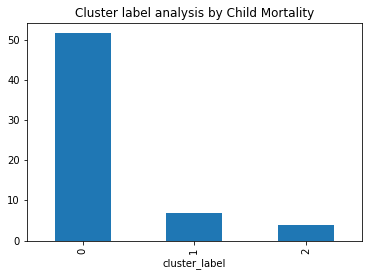

In [48]:
# Plotting the Child_mort by grouping the Cluster Label

country_data_1.groupby('cluster_label')['child_mort'].mean().plot(kind='bar')
plt.title('Cluster label analysis by Child Mortality')
plt.show()

 All the countries with high Child Mortality rate are assigned at lebel 0, Previously it was at lebel 2 for K-Means algorithm.

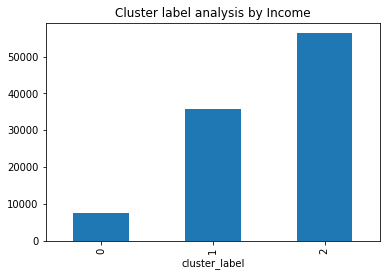

In [49]:
# Plotting the Income by grouping the Cluster Label

country_data_1.groupby('cluster_label')['income'].mean().plot(kind='bar')
plt.title('Cluster label analysis by Income')
plt.show()

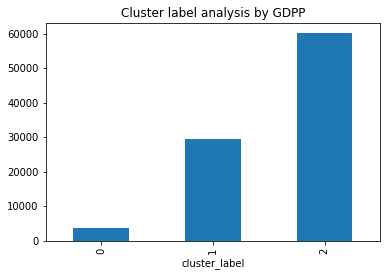

In [50]:
# Plotting the GDP by grouping the  Cluster Label

country_data_1.groupby('cluster_label')['gdpp'].mean().plot(kind='bar')
plt.title('Cluster label analysis by GDPP')
plt.show()

In [51]:
# Low income, Low GDP and High Child_mort
# Filter the data for that clsuter

country_data_1[country_data_1['cluster_label'] == 0].head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,k_label,cluster_label
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2,0
5,Argentina,14.5,1946.70,834.3000,1648.000,18700.0,20.90,75.8,2.37,10300.0,0,0


### Finalizing the List of Countries by Child Mortality, Income & GDP

Now we are going to finalise our list for countries from the result that we have got by **K-Means Algorithm and accordingly we are sorting our list.** Because the result from K-Means is far more self explanable and accurate from business parspective.

In [52]:
# Filtering the list by Child Mortality

country_data_1[country_data_1['k_label'] == 2].sort_values(by=['child_mort'], ascending=[False]).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,k_label,cluster_label
66,Haiti,208.0,101.286,45.7442,428.314,1500.0,5.45,32.1,3.3300,662.0,2,0
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220.0,17.20,55.0,5.2000,399.0,2,0
32,Chad,150.0,330.096,40.6341,390.195,1930.0,6.39,56.5,6.5636,897.0,2,0
31,Central African Republic,149.0,52.628,17.7508,118.190,888.0,2.01,47.5,5.2100,446.0,2,0
97,Mali,137.0,161.424,35.2584,248.508,1870.0,4.37,59.5,6.5500,708.0,2,0


In [53]:
# Filtering the List by Income

country_data_1[country_data_1['k_label'] == 2].sort_values(by=['income'], ascending=[True]).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,k_label,cluster_label
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.5400,334.0,2,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.0200,327.0,2,0
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.2600,231.0,2,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,6.5636,348.0,2,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.01,47.5,5.2100,446.0,2,0


In [54]:
# Filtering the List by GDP

country_data_1[country_data_1['k_label']==2].sort_values(by='gdpp', ascending= True).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,k_label,cluster_label
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.2600,231.0,2,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.0200,327.0,2,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.5400,334.0,2,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,6.5636,348.0,2,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.2000,399.0,2,0


## Conclusion & Recommendation

**After perform the EDA and the K-Means & Hierarchical clustering we can come to the conclusion that follows...**

**1. For a countries major development is basically depends on some major factors i.e. Income per capita, GDP, Health infrastructues, Child Mortality etc.**

**2. If a country's GDP is low and also per capita Income is low then surely it can say that this particular country is Socio-Economically very week, where as if these two factor for a country is high then this country hold a strong position socio-economically. These are the major two factors that can play a significant role for any country's development.**

**3. Apart from this if the Child Mortality rate is very high for a ccountry, then it can surely say that in terms of Health infrastructures this country belongs to a non healthy condition.**

**4. So we can recommendate the NGO that they can take into consideration of 1st 5 countries filtering by *Child Mortality* rate i.e. *Haiti, Sierra Leone, Chad, Central African Republic, Mali*. Because from our basic Understanding we know that if a country's child mortality is high then obiously their health infrastructure is very much poor. So for a NGO this could be their prime responsibility to keep ahead their hand for those countries'health development and plan their amount of investment accordingly.**

**5. Apart from that the NGO can also look after for the countries which GDP and Income status is very low like - *Burundi, Congo, Dem. Rep*. They also can look after all those countries which are being cluster at lebel 0 and plan their investment accordingly. Because all the countries which are been clustered at label 0, they are either Health and Socio-economically undeveloped or poorly developed. But the major focus to be surrounded for all those names which we have mentioned earlier.**